### Alex Stute - Final Project Work

Initial Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Loading Data

In [2]:
import os
os.chdir('c:\\Users\\stute\\OneDrive - University of Vermont\\Fall 2024\\Machine Learning\\Final Project Things\\CS5990-Group7-Final-Project')

PATH_TO_TRAINING_DATA = '\\archive\\sign_mnist_train'
PATH_TO_TEST_DATA = '\\archive\\sign_mnist_test'

# Get the training data
os.chdir(os.getcwd() + PATH_TO_TRAINING_DATA)
train_data = pd.read_csv(os.getcwd() + '\\sign_mnist_train.csv')

# Moves up two directories
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

# Get the testing data
os.chdir(os.getcwd() + PATH_TO_TEST_DATA)
test_data = pd.read_csv(os.getcwd() + '\\sign_mnist_test.csv')

# Moves up two directories
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

'c:\\Users\\stute\\OneDrive - University of Vermont\\Fall 2024\\Machine Learning\\Final Project Things\\CS5990-Group7-Final-Project'

Check data loaded properly

In [3]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Test printing an image

In [30]:
row_1_label = train_data.iloc[0][0]
row_1_pixels = train_data.iloc[0][1:785]

C:\Users\stute\AppData\Local\Temp\ipykernel_36372\470199590.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_1_label = train_data.iloc[0][0]


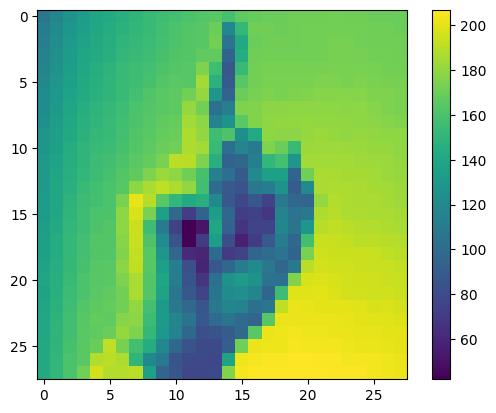

In [31]:
# Images are 28x28, so to view a row, reshape it into a 28x28 array
row_1_train = np.reshape(row_1_pixels, (28,28))
plt.imshow(row_1_train)
plt.colorbar()
plt.show()